In [1]:
import numpy as np 
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Flatten, Dense 
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow as tf

In [2]:
vgg = tf.keras.applications.VGG16(
    input_shape=[100,100,3], include_top= False, weights='imagenet')

In [3]:
x = Flatten()(vgg.output)
x = Dense(4, activation='sigmoid')(x)
model = Model(vgg.input, x)

In [4]:
def my_generator(batch_size=64):
    while True:
        for _ in range(50):
            # generate X of size (batch_size, H, W, 3)
            X = np.zeros((batch_size, 100, 100, 3)) # Already all black
            Y = np.zeros((batch_size, 4))
            
            for i in range(batch_size):
                row0 = np.random.randint(90)
                col0 = np.random.randint(90) # Gotta leave space for actual box
                row1 = np.random.randint(row0, 100)
                col1 = np.random.randint(col0, 100)
                X[i,row0:row1,col0:col1,:] = 1
                # Generate y of size (batch_size, 4)
                # gotta generate 4 numbers
                # first 2 numbers: top-left corner
                # second 2 numbers: heigt, width
                Y[i,0] = row0/ 100
                Y[i,1] = col0/ 100
                Y[i,2] = (row1 - row0) / 100 
                Y[i,3] = (col1 - col0) / 100
            yield X, Y

In [5]:
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001))

In [6]:
model.fit(
    my_generator(),
    steps_per_epoch=50,
    epochs=5
)

Epoch 1/5


50/50 [==============================] - 13s 103ms/step - loss: 1.0903
Epoch 2/5
50/50 [==============================] - 5s 103ms/step - loss: 0.5266
Epoch 3/5
50/50 [==============================] - 4s 82ms/step - loss: 0.5113
Epoch 4/5
50/50 [==============================] - 4s 82ms/step - loss: 0.5079
Epoch 5/5
50/50 [==============================] - 4s 83ms/step - loss: 0.5071


In [7]:
from matplotlib.patches import Rectangle

# make predictions
def make_prediction():
    # need to create random images
    x = np.zeros((100,100,3)) #image size
    row0 = np.random.randint(90)
    col0 = np.random.randint(90) 
    row1 = np.random.randint(row0, 100)
    col1 = np.random.randint(col0, 100)
    x[row0:row1,col0:col1,:] = 1
    print(row0, col0, row1, col1)
    
    # Predict X 
    X = np.expand_dims(x,0)
    p = model.predict(X)[0]
    
    # Draw the box
    fig, ax = plt.subplots(1)
    ax.imshow(x)
    rect = Rectangle(
        (p[1]*100, p[0]*100),
        p[3]* 100, p[2]*100, linewidth=1, edgecolor='r', facecolor='none')
    
    ax.add_patch(rect)
    plt.show

64 86 75 91
1/1 [==============================] - 0s 259ms/step


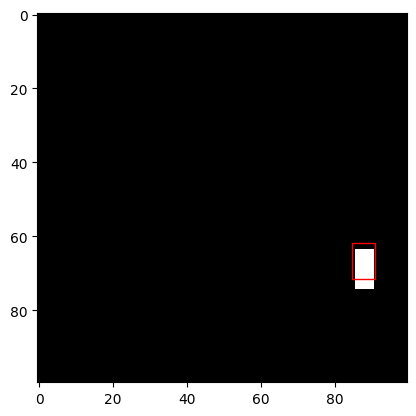

In [8]:
make_prediction()

In [11]:
print(tf.__version__)

2.10.1


In [13]:
from tensorflow.keras.preprocessing import image 

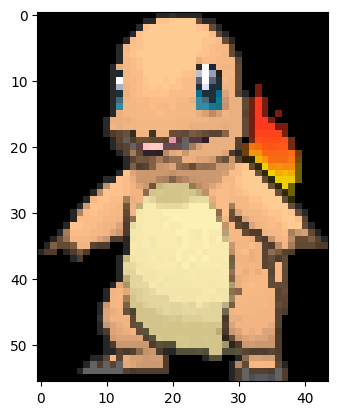

In [14]:
ch = image.load_img('styles/charmander-tight.png')
plt.imshow(ch)
plt.show()

In [15]:
np.array(ch).shape

(56, 44, 3)

In [16]:
from imageio.v3 import imread

In [17]:
ch = imread('styles/charmander-tight.png')

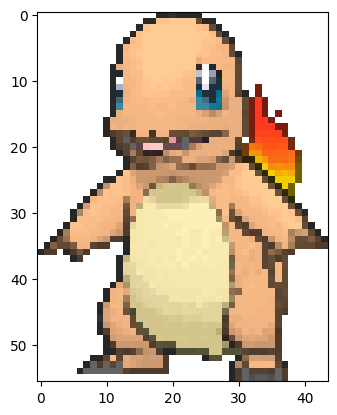

In [18]:
plt.imshow(ch)

In [19]:
type(ch)
ch.shape

(56, 44, 4)

- 4th channel for png encode transparency as well compared to jpeg
- the alpha channel tells us how transparent each pixel is

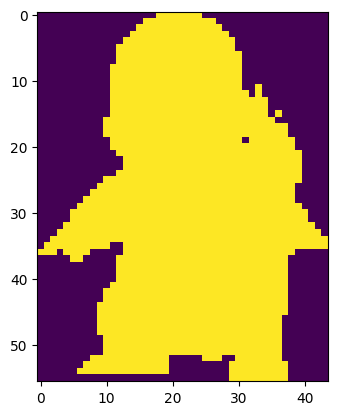

In [20]:
# Whats in the 4th channel?
plt.imshow(ch[:,:,3])
plt.show()

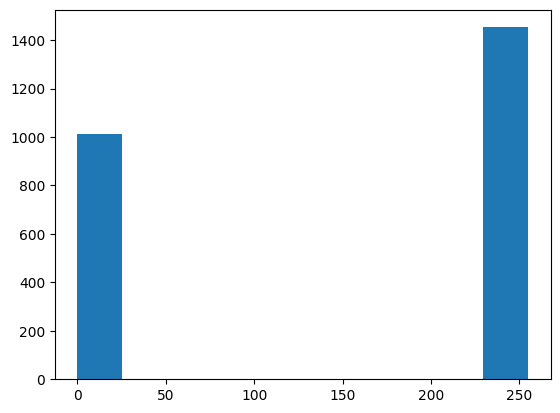

{0, 255}

In [21]:
plt.hist(ch[:,:,3].flatten())
plt.show()
set(ch[:,:,3].flatten())

In [22]:
POKE_DIM = 200
ch = np.array(ch)
CH_H, CH_W, _ = ch.shape

def pokemon_generator(batch_size=64):
    while True:
        for _ in range(50):
            X = np.zeros((batch_size, POKE_DIM, POKE_DIM, 3))
            Y = np.zeros((batch_size, 4))
            
            for i in range(batch_size):
                row0 = np.random.randint(POKE_DIM - CH_H)
                col0 = np.random.randint(POKE_DIM - CH_W)
                row1 = row0 + CH_H
                col1 = col0 + CH_W
                X[i,row0:row1,col0:col1,:] = ch[:,:,:3]
                Y[i,0] = row0/POKE_DIM
                Y[i,1] = col0/POKE_DIM
                
                # make pokemon different sizes
                Y[i,2] = (row1 - row0)/POKE_DIM
                Y[i,3] = (col1 - col0)/POKE_DIM
                
            yield X / 255., Y

In [23]:
def make_model():
    vgg = tf.keras.applications.VGG16(
        input_shape=[POKE_DIM, POKE_DIM, 3],
        include_top=False,
        weights='imagenet')
    
    x = Flatten()(vgg.output)
    x = Dense(4, activation='sigmoid')(x)
    model = Model(vgg.input, x)
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001))
    return model

In [24]:
model = make_model()
model.fit_generator(
    pokemon_generator(),
    steps_per_epoch=50,
    epochs=5
)

Epoch 1/5


C:\Users\kenny\AppData\Local\Temp\ipykernel_19400\1521849318.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


50/50 [==============================] - 35s 368ms/step - loss: 0.6851
Epoch 2/5
50/50 [==============================] - 16s 321ms/step - loss: 0.5572
Epoch 3/5
50/50 [==============================] - 15s 303ms/step - loss: 0.5534
Epoch 4/5
50/50 [==============================] - 15s 305ms/step - loss: 0.5541
Epoch 5/5
50/50 [==============================] - 15s 306ms/step - loss: 0.5520


In [25]:
# make predictions
def pokemon_prediction():
    # need to create random images
    x = np.zeros((POKE_DIM, POKE_DIM,3)) #image size
    row0 = np.random.randint(POKE_DIM - CH_H)
    col0 = np.random.randint(POKE_DIM - CH_W) 
    row1 = row0 + CH_H
    col1 = col0 + CH_W
    x[row0:row1,col0:col1,:] = ch[:,:,:3]
    print('true:', row0, col0, row1, col1)
    
    # Predict X 
    X = np.expand_dims(x,0) / 255.
    p = model.predict(X)[0]
    
    #calculate target/loss
    y = np.zeros(4)
    y[0] = row0/POKE_DIM
    y[1] = col0/POKE_DIM
    y[2] = (row1 - row0)/POKE_DIM
    y[3] = (col1 - col0)/POKE_DIM
    
    # Draw box
    row0 = int(p[0]*POKE_DIM)
    col0 = int(p[1]*POKE_DIM)
    row1 = int(row0 + p[2]*POKE_DIM)
    col1 = int(col0 + p[3]*POKE_DIM)
    print('pred:', row0, col0, row1, col1)
    print('loss:', -np.mean(y * np.log(p) + (1-y)*np.log(1-p)))
    
    fig,ax = plt.subplots(1)
    ax.imshow(x.astype(np.uint8))
    rect= Rectangle(
        (p[1]*POKE_DIM, p[0]*POKE_DIM),
        p[3]* POKE_DIM, p[2]*POKE_DIM, linewidth=1, edgecolor='r', facecolor='none')  
    ax.add_patch(rect)
    plt.show


true: 73 56 129 100
1/1 [==============================] - 0s 376ms/step
pred: 75 55 131 99
loss: 0.592352082580328


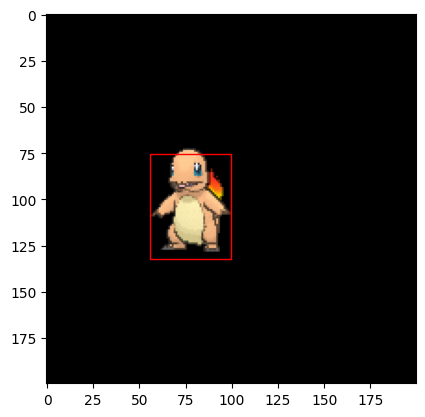

In [26]:
pokemon_prediction()

In [27]:
from skimage.transform import resize

In [28]:
def pokemon_generator_with_resize(batch_size=64):
    while True:
        for _ in range(50):
            X = np.zeros((batch_size, POKE_DIM, POKE_DIM, 3))
            Y = np.zeros((batch_size, 4))
            
            for i in range(batch_size):
                scale = 0.5 + np.random.random() # 0.5,1.5
                new_height = int(CH_H * scale)
                new_width = int(CH_W * scale)
                obj = resize(
                    ch,
                    (new_height, new_width),
                    preserve_range=True).astype(np.uint8) # stays in range 0-255
                
                row0 = np.random.randint(POKE_DIM - new_height)
                col0 = np.random.randint(POKE_DIM - new_width) 
                row1 = row0 + new_height
                col1 = col0 + new_width
                X[i,row0:row1,col0:col1,:] = obj[:,:,:3]
                Y[i,0] = row0/POKE_DIM
                Y[i,1] = col0/POKE_DIM
                
                # make pokemon different sizes
                Y[i,2] = (row1 - row0)/POKE_DIM
                Y[i,3] = (col1 - col0)/POKE_DIM
            
            yield X/255., Y

In [29]:
def make_model2():
    vgg = tf.keras.applications.VGG16(
        input_shape=[POKE_DIM, POKE_DIM, 3],
        include_top=False,
        weights='imagenet'
    )
    x = Flatten()(vgg.output)
    x = Dense(4, activation='sigmoid')(x)
    model = Model(vgg.input, x)
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001))
    return model

In [30]:
model = make_model2()
model.fit(
    pokemon_generator_with_resize(),
    steps_per_epoch=50,
    epochs=5
)

Epoch 1/5
50/50 [==============================] - 18s 341ms/step - loss: 0.6925
Epoch 2/5
50/50 [==============================] - 15s 306ms/step - loss: 0.5502
Epoch 3/5
50/50 [==============================] - 15s 308ms/step - loss: 0.5572
Epoch 4/5
50/50 [==============================] - 19s 377ms/step - loss: 0.5447
Epoch 5/5
50/50 [==============================] - 16s 313ms/step - loss: 0.5429


In [31]:
def pokemon_prediction_with_resize():
    scale = 0.5 + np.random.random()
    new_height = int(CH_H * scale)
    new_width = int(CH_W * scale)
    obj = resize(
        ch,
        (new_height, new_width),
        preserve_range=True).astype(np.uint8)
    
    x = np.zeros((POKE_DIM, POKE_DIM, 3))
    row0 = np.random.randint(POKE_DIM - new_height)
    col0 = np.random.randint(POKE_DIM - new_width) 
    row1 = row0 + new_height
    col1 = col0 + new_width
    x[row0:row1,col0:col1,:] = obj[:,:,:3]
    print('true:', row0, col0, row1, col1)
    
    # Predict
    X = np.expand_dims(x,0) / 255.
    p = model.predict(X)[0]
    
    # Draw
    row0 = int(p[0]*POKE_DIM)
    col0 = int(p[1]*POKE_DIM)
    row1 = int(row0 + p[2]*POKE_DIM)
    col1 = int(col0 + p[3]*POKE_DIM)
    print('pred:', row0, col0, row1, col1)
    
    fig,ax = plt.subplots(1)
    ax.imshow(x.astype(np.uint8))
    rect= Rectangle(
        (p[1]*POKE_DIM, p[0]*POKE_DIM),
        p[3]* POKE_DIM, p[2]*POKE_DIM, linewidth=1, edgecolor='r', facecolor='none')  
    ax.add_patch(rect)
    plt.show

true: 74 109 145 165
1/1 [==============================] - 0s 97ms/step
pred: 76 109 146 162


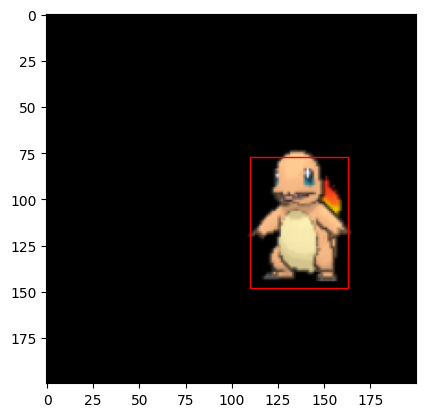

In [32]:
pokemon_prediction_with_resize()

In [33]:
def pokemon_generator_flip(batch_size=64):
    while True:
        for _ in range(50):
            X = np.zeros((batch_size, POKE_DIM, POKE_DIM, 3))
            Y = np.zeros((batch_size, 4))
            
            for i in range(batch_size):
                row0 = np.random.randint(POKE_DIM - CH_H)
                col0 = np.random.randint(POKE_DIM - CH_W)
                row1 = row0 + CH_H
                col1 = col0 + CH_W
                
                if np.random.random() < 0.5:
                    obj = np.fliplr(ch)
                else:
                    obj = ch
                    
                X[i,row0:row1,col0:col1,:] = obj[:,:,:3]
                Y[i,0] = row0/POKE_DIM
                Y[i,1] = col0/POKE_DIM
                
                # make pokemon different sizes
                Y[i,2] = (row1 - row0)/POKE_DIM
                Y[i,3] = (col1 - col0)/POKE_DIM
            
            yield X/255., Y

In [34]:
model = make_model()
model.fit(
    pokemon_generator_flip(),
    steps_per_epoch=50,
    epochs=5
)

Epoch 1/5
50/50 [==============================] - 19s 374ms/step - loss: 0.5997
Epoch 2/5
50/50 [==============================] - 15s 310ms/step - loss: 0.5553
Epoch 3/5
50/50 [==============================] - 15s 308ms/step - loss: 0.5527
Epoch 4/5
50/50 [==============================] - 16s 313ms/step - loss: 0.5545
Epoch 5/5
50/50 [==============================] - 16s 312ms/step - loss: 0.5515


In [35]:
def pokemon_prediction_flip():
    x = np.zeros((POKE_DIM, POKE_DIM, 3))
    row0 = np.random.randint(POKE_DIM - CH_H)
    col0 = np.random.randint(POKE_DIM - CH_W)
    row1 = row0 + CH_H
    col1 = col0 + CH_W
    
    if np.random.random() < 0.5:
        obj = np.fliplr(ch)
    else:
        obj = ch
    
    x[row0:row1,col0:col1,:] = obj[:,:,:3]
    print('true:', row0, col0, row1, col1)
    # Predict
    X = np.expand_dims(x,0) / 255.
    p = model.predict(X)[0]
    
    # Draw
    row0 = int(p[0]*POKE_DIM)
    col0 = int(p[1]*POKE_DIM)
    row1 = int(row0 + p[2]*POKE_DIM)
    col1 = int(col0 + p[3]*POKE_DIM)
    print('pred:', row0, col0, row1, col1)
    
    fig,ax = plt.subplots(1)
    ax.imshow(x.astype(np.uint8))
    rect= Rectangle(
        (p[1]*POKE_DIM, p[0]*POKE_DIM),
        p[3]* POKE_DIM, p[2]*POKE_DIM, linewidth=1, edgecolor='r', facecolor='none')  
    ax.add_patch(rect)
    plt.show

true: 0 128 56 172
1/1 [==============================] - 0s 85ms/step
pred: 2 127 59 171


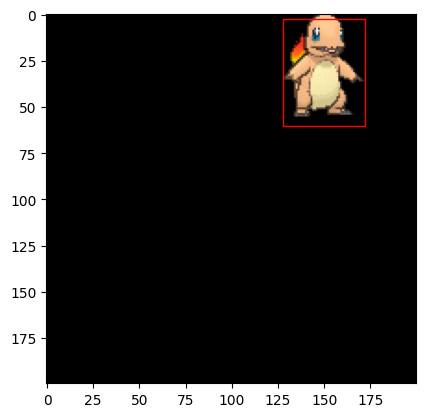

In [36]:
pokemon_prediction_flip()